In [1]:
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2

sys.path.append("..")
from cv.locator import DroneLocator
from cv.dewarp import dewarp
import os


imgs_path = "../imgs/m4/"
landing_preds_path = os.path.join(imgs_path, "landing_det")
landing_pad_imgs = (
    [
        os.path.join(landing_preds_path, name) 
        for name in os.listdir(landing_preds_path)
    ]
)

gantry_preds_path = os.path.join(imgs_path, "end_offsets")
gantry_imgs = (
    [
        os.path.join(gantry_preds_path, name) 
        for name in os.listdir(gantry_preds_path)
    ]
)

# Adjusting Hyperparameters for button color filter in HSV space

In [2]:
from PIL import Image
locator = DroneLocator(
    linreg_path= "../cv/offset_model.pkl",
    show_circles=True,
    rough_radius_range= (20, 60),
    fine_radius_range= (30, 60),
    qr2but_range=(250, 300), 
    button_color_hsv_low = (25, 50, 100),
    button_color_hsv_high = (40, 255, 255),
)

# for i in gantry_imgs:
#     print(os.path.basename(i))
#     img = locator.imread(i)
#     plt.figure(figsize=(10,10))
#     plt.imshow(locator.color_filt(img), cmap="gray")
#     plt.show()

# Testing performance of locator 

0_0_20.jpg


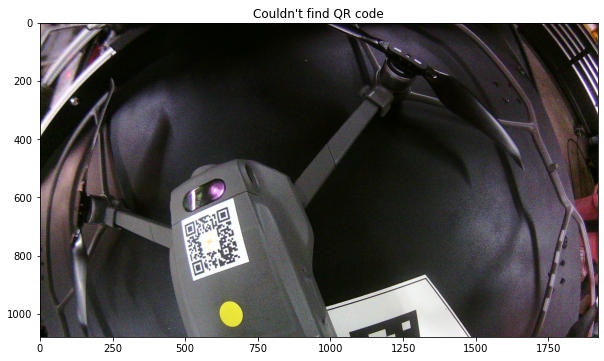

-20_0_0.jpg


ValueError: too many values to unpack (expected 2)

<Figure size 720x720 with 0 Axes>

In [3]:
from sklearn.linear_model import LinearRegression

locator = DroneLocator(
    linreg_path= "../cv/offset_model.pkl",
    canny_thresholds=(200, 200),
    show_circles=False,
    rough_radius_range= (20, 60),
    fine_radius_range= (30, 60),
    qr2but_range=(150, 600), 
    button_color_hsv_low = (25, 50, 100),
    button_color_hsv_high = (40, 255, 255),
)

# print(gantry_imgs)
for i in gantry_imgs:
    print(os.path.basename(i))
    img = locator.imread(i)
    plt.figure(figsize=(10,10))
    results = locator(img, True)

In [1]:
with_drone=set([
    3, 5, 7, 8, 12, 13, 18, 19, 20, 21, 22, 23, 25, 27, 28, 33, 35, 36, 37, 41, 42, 44, 45, 46, 50, 51,52, 53, 
])
len(with_drone)

28

In [4]:
import tensorflow
